<a href="https://colab.research.google.com/github/jdomeneghini/Data_Science/blob/master/Avalia%C3%A7%C3%A3odeRiscodeCredito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**AVALIAÇÃO DE RISCO DE CRÉDITO**



![imagerisk](https://user-images.githubusercontent.com/55714855/97733653-e4354b00-1ab6-11eb-98b7-3e98e4a6d4a8.png)

No Brasil, milhões de pedidos de crédito são eftuados e os solicitantes passam por um processo chamado análise de crédito.

A análise de crédito é um meio das instituições financeiras se protegerem contra a inadimplência, e busca avaliar se o cliente terá a capacidade de arcar com o quantidade desejada.

Grandes bancos e Fintechs têm apostado cada vez mais em modelos de Machine Learning para previnir a inadimplência de alguns clientes.

O conjunto de dados a ser utilizado neste projeto de Data Science faz parte de uma competição realizada pela Startup Nubank.

***Objetivo***

O objetivo deste desafio é criar um modelo no qual possa prever a probabilidade de um cliente ser inadimplente. 
Essa avaliação deve ser realizada no momento em que o cliente solicita o cartão (normalmente no primeiro contato com a instituição).

Espera-se que o modelo seja capaz de minimizar perdas financeiras da startup, e também, minimizar falsos positivos.

**Importando os dados e as bibliotecas necessárias**

Os dados podem ser obtidos neste [link]((https://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0)).

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scikitplot as skplt

from sklearn.model_selection import train_test_split 
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

df = pd.read_csv('https://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0')

# definir o estilo do seaborn para os plots
sns.set_style()

# filtrar mensagens de warning
import warnings
warnings.filterwarnings('ignore')


**ANÁLISE EXPLORATÓRIA DE DADOS**

Nesta primeira etapa irei examinar as informações deste dataframe.

In [ ]:
# dimensões do df
print("DIMENSÕES DO DATAFRAME:")
print("Linhas:\t\t{}".format(df.shape[0]))
print("Colunas:\t{}".format(df.shape[1]))


DIMENSÕES DO DATAFRAME:
Linhas:		45000
Colunas:	43


In [ ]:
#ver as 5 primeiras entradas do dataset
df.head()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,reason,income,facebook_profile,state,zip,channel,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,Ernn+uVXCMq/6ARrBCcd+A==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,NaN,0.0,0.0,18.0,18.0,07:52:34,444,outlook.com,NaN,2,0.0,51.0,leidelaura,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,NaN,39726.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,rlWIXTBO+VOa34+SpGyhlQ==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,50.0,0.0,0.0,14.0,14.0,02:34:29,346,gmail.com,0.0,1,0.0,17.0,diocezio,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65023.65,NaN,Ygq6MsM98oC8yceExr69Ig==,PjTIDfJsK0DKL9fO7vuW2g==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,10.0,NaN,00:60:02,6,gmail.com,NaN,2,NaN,9.0,veralucia,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,NaN,54591.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,68830.01,False,KET/Pmr6rHp1RJ/P9ymztw==,Cc/kWDLQH3dpHv5HU+pLVA==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiE56f...,n+xK9CfX0bCn77lClTWviw==,NaN,1.0,0.0,19.0,19.0,11:20:49,406,spgov.com,NaN,3,NaN,38.0,venice,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,60011.29,True,xsd3ZdsI3356I3xMxZeiqQ==,i036nmJ7rfxo+3EvCD7Jnw==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,11.0,NaN,13:39:03,240,gmail.com,0.0,2,1.0,46.0,darzisa,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN


***Algumas conclusões inicias:***

- De antemão é possível identificar algumas colunas com valores codificados, muitas com dados pessoais de cada cliente (por exemplo *ids, score_1, score_2, state, zip, job_name*, entre outras), uma forma de garantir uma segurança na confidencialidade das informações. 
- A classe é a variável 'target_default', ela é a classificadora  de inadimplência, sendo: 

  *TRUE* - inadimplente; 
  
  *FALSE* - não inadimplente

- Uma coluna com um classificador de risco (risk_rate) para cada cliente.
- A coluna 'target_fraud' seria a variável alvo de outro modelo para este mesmo dataset, onde o objetivo seria a detecção de fraude.
- Algumas colunas mostrando localização, como latitude e longitude ('lat_lon'- em formato string contendo uma tupla com as coordenadas), estado e código postal, informações até interessantes para outros tipos de análises levando em consideração as localidades dos clientes, como este não é o objetivo dessa análise não me aprofundarei.


In [ ]:
#resumo estatistico 
df.describe()

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,shipping_zip_code
count,44438.000000,45000.000000,45000.000000,45000.000000,44438.000000,15044.000000,15044.000000,31200.000000,4.443800e+04,18455.000000,44303.000000,44426.000000,44438.000000,33456.000000,45000.000000,22372.0,45000.000000,29876.000000,42767.000000,45000.000000,45000.00,45000.000000
mean,347.983258,100.006797,0.500037,99.925228,0.296717,13782.341991,41.763893,34381.951154,7.160739e+04,35.069737,0.076270,0.004569,10.696701,11.068119,247.537000,0.0,1.501067,0.503381,12.534781,500.399800,inf,33923.514844
std,110.429165,3.178080,0.288326,10.016549,0.101933,8077.571933,10.252705,36586.982218,5.185897e+04,21.663194,0.274052,0.079400,4.592463,4.595501,146.118398,0.0,1.114941,0.499997,126.530487,287.968873,NaN,12692.406382
min,0.000000,86.191572,0.000035,60.663039,0.000000,1005.180000,36.000000,0.000000,4.821180e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-999.000000,0.000000,403.00,12001.000000
25%,270.000000,97.867036,0.252150,93.198353,0.220000,7519.502500,36.000000,10000.000000,4.501078e+04,17.000000,0.000000,0.000000,7.000000,8.000000,120.000000,0.0,1.000000,0.000000,11.000000,252.000000,50948.25,22937.000000
50%,340.000000,100.018900,0.500753,99.974796,0.290000,12023.465000,36.000000,25647.000000,6.126676e+04,32.000000,0.000000,0.000000,10.000000,10.000000,248.000000,0.0,2.000000,1.000000,27.000000,503.000000,101779.00,33896.000000
75%,420.000000,102.141797,0.748816,106.640275,0.360000,19220.270000,36.000000,47086.750000,8.601923e+04,50.000000,0.000000,0.000000,13.000000,14.000000,375.000000,0.0,2.000000,1.000000,43.000000,747.000000,151337.25,44910.000000
max,990.000000,113.978234,0.999973,142.192400,0.900000,35059.600000,60.000000,448269.000000,5.000028e+06,141.000000,5.000000,5.000000,49.000000,49.000000,500.000000,0.0,3.000000,1.000000,59.000000,1000.000000,inf,56000.000000


***Observação do resumo das principais informações estatísticas:***

* A coluna 'external_data_provider_credit_checks_last_2_year' possui valores mínimos, máximos e desvio-padrão iguais a zero.
* A coluna 'reported_income' apresenta valores *inf*, que irão interferir na análise e modelo. Substituirei os valores do tipo 'np.inf' por 'np.nan' para trabalhar com os dados.

* A coluna 'external_data_provider_email_seen_before' apresenta o valor mínimo de -999, o que é estranho ao se considerar as outras informações. 
Vou verificar plotando um gráfico abaixo:

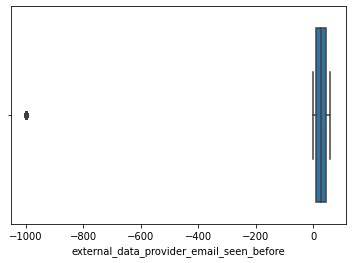

In [ ]:
sns.boxplot(df['external_data_provider_email_seen_before'])
plt.show()


Por está análise concluo que esse dados são *outliers* ou foram tratados inadequadamente. Substituirei à frente os valores iguais a -999 por 'np.nan'.


Após esta etapa, irei verificar os tipos de cada variáveis e também a quantidade de valores ausentes em cada uma.


In [ ]:
#tipos das variaveis
df.dtypes

ids                                                  object
target_default                                       object
score_1                                              object
score_2                                              object
score_3                                             float64
score_4                                             float64
score_5                                             float64
score_6                                             float64
risk_rate                                           float64
last_amount_borrowed                                float64
last_borrowed_in_months                             float64
credit_limit                                        float64
reason                                               object
income                                              float64
facebook_profile                                     object
state                                                object
zip                                     

In [ ]:
#variaveis com valores ausentes
(df.isnull().sum()/df.shape[0]).sort_values(ascending=False)

target_fraud                                        0.966178
last_amount_borrowed                                0.665689
last_borrowed_in_months                             0.665689
ok_since                                            0.589889
external_data_provider_credit_checks_last_2_year    0.502844
external_data_provider_credit_checks_last_year      0.336089
credit_limit                                        0.306667
n_issues                                            0.256533
facebook_profile                                    0.099067
marketing_channel                                   0.079511
job_name                                            0.074133
target_default                                      0.072422
external_data_provider_email_seen_before            0.049622
lat_lon                                             0.030289
user_agent                                          0.016044
n_bankruptcies                                      0.015489
n_defaulted_loans       

Algumas variáveis possuem um pouco mais da metade de seus dados ausentes, algumas poderemos desconsiderar, pois para o desafio proposto não serão relevantes.

E somente a variável 'target_fraud' que como eu já havia mencionado acima, é uma classe de outro modelo, possui quase 100% dos dados ausentes, então ela também poderá ser eliminada.

As outras variáveis irei analisar melhor abaixo:

In [ ]:
#valores unicos nas features
df.nunique().sort_values()

external_data_provider_credit_checks_last_2_year        1
channel                                                 1
target_fraud                                            2
target_default                                          2
external_data_provider_credit_checks_last_year          2
facebook_profile                                        2
last_borrowed_in_months                                 2
external_data_provider_credit_checks_last_month         4
n_defaulted_loans                                       5
real_state                                              5
email                                                   6
n_bankruptcies                                          6
score_1                                                 7
marketing_channel                                       9
shipping_state                                         25
score_2                                                35
n_issues                                               44
n_accounts    

Essa função serve para verificarmos a quantidades de dados únicos em cada variável. 

Vamos as *observações:*

- As primeiras variáveis 'external_data_provider_credit_checks_last_2_year' e 'channel' possuem um único valor em todas as linhas, logo elas não serão útil para o modelo. 
- Algumas outras possuem também poucos valores e eliminarei mais à frente, levando em consideração que podem não acrescentar valor útil ao modelo.
- As ultimas duas variáveis que possuem em cada linhas 45 mil valores diferentes, também será desconsiderada, pois não são informações relevantes para esta análise.

Antes de prosseguir para a limpeza e preparação dos dados vamos conferir a quantidade de inadimplentes presentes neste dataset.

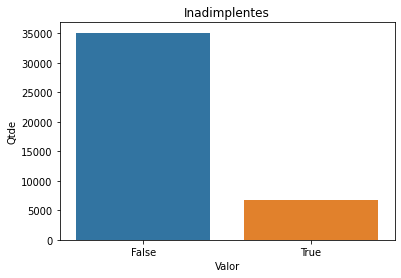

False    35080
True      6661
Name: target_default, dtype: int64

Quantos % de inadimplentes no dataset: 14.8022%



In [ ]:
fig, ax = plt.subplots()
sns.countplot(df.target_default, ax=ax)
ax.set_title('Inadimplentes')
ax.set_xlabel('Valor')
ax.set_ylabel('Qtde')
plt.show()


print(df.target_default.value_counts())
print('\nQuantos % de inadimplentes no dataset: {:.4f}%\n'.format(df[df.target_default ==1].shape[0]/ df.shape[0] * 100))



Claramente a base de dados está desbalanceada, e na hora de criar um modelo de algoritmo com estes dados, ele aprenderá mais sobre a classe que tem maiores quantidades e então será um modelo enviesado, então, precisarei balancear estes dados.





**LIMPEZA E PREPARAÇÃO DOS DADOS**

Nesta etapa, farei uma limpeza dos dados e prepará-los para criar o modelo.


In [19]:
df_clean = df.copy()

#subsitituir inf por NaN na variavel 'reported_income'
df_clean['reported_income'] = df_clean['reported_income'].replace(np.inf, np.nan)
           
#substituir -999 por NaN na variavel external_data_provider_email_seen_before
df_clean.loc[df_clean['external_data_provider_email_seen_before'] == -999.0,
             'external_data_provider_email_seen_before'] = np.nan
            
#eliminar colunas sem informação aparente ou que demandam mais pesquisa
drop_var= ['ids', 'target_fraud', 'external_data_provider_credit_checks_last_2_year','channel','reason',
           'state', 'job_name', 'zip', 'external_data_provider_first_name','lat_lon', 'shipping_zip_code', 
           'user_agent', 'profile_tags', 'email', 'marketing_channel', 'external_data_provider_fraud_score', 
           'external_data_provider_first_name', 'profile_phone_number', 'shipping_state', 'facebook_profile']          
df_clean.drop(labels= drop_var, axis=1, inplace=True)

#eliminar as entradas NaN na target_default
df_clean.dropna(subset=['target_default'], inplace=True)

#substituicao de valores ausentes NaN por 0
df_clean.last_amount_borrowed.fillna(value=0, inplace=True)
df_clean.last_borrowed_in_months.fillna(value= 0, inplace=True)
df_clean.n_issues.fillna(value=0, inplace=True)


Em muitas destas features não temos maiores informações, e devido aos muitos valores nulos em algumas delas podemos identificar que alguns itens não são obrigatórios o preenchimento e em outros não é aplicável o preenchimento. 

Para estes casos, irei substituir o NaN por 0, as variáveis numéricas pelo valor da mediana e as variáveis categóricas para o valor mais frequente. 

Para fazer estas modificações utilizarei uma ferramenta do SKLearn chamada 'SimpleImputer'.


In [20]:
from sklearn.impute import SimpleImputer

num_df= df_clean.select_dtypes(exclude='object').columns
cat_df= df_clean.select_dtypes(include='object').columns

#variaveis numericas
imputer= SimpleImputer(missing_values= np.nan, strategy='median')
imputer= imputer.fit(df_clean.loc[:, num_df])
df_clean.loc[:, num_df] = imputer.transform(df_clean.loc[:, num_df])

#variaveis categoricas
imputer= SimpleImputer(missing_values= np.nan, strategy='most_frequent')
imputer= imputer.fit(df_clean.loc[:, cat_df])
df_clean.loc[:, cat_df] = imputer.transform(df_clean.loc[:, cat_df])


Vamos verificar os valores nulos:


In [ ]:
df_clean.isnull().sum()

target_default                                     0
score_1                                            0
score_2                                            0
score_3                                            0
score_4                                            0
score_5                                            0
score_6                                            0
risk_rate                                          0
last_amount_borrowed                               0
last_borrowed_in_months                            0
credit_limit                                       0
income                                             0
real_state                                         0
ok_since                                           0
n_bankruptcies                                     0
n_defaulted_loans                                  0
n_accounts                                         0
n_issues                                           0
application_time_applied                      

In [ ]:
df_clean.shape

(41741, 24)

Feito! 

Próximo passo irei usar uma função de padronização de escala nas variáveis numéricas, chamada 'StandardScaler'.

In [21]:
from sklearn.preprocessing import StandardScaler

      
scaled_df= df_clean.copy()
num_cols= scaled_df.drop('target_default', axis=1).select_dtypes(exclude='object').columns

scaled_df[num_cols]= StandardScaler().fit_transform(scaled_df[num_cols].values)


Continuando com a preparação dos dados para criação do modelo, irei utilizar a técnica 'LabelEncoder' para transformar as variáveis catégoricas em forma de labels numéricas.

In [22]:
from sklearn.preprocessing import LabelEncoder

encoded_df = scaled_df.copy()
#extrair colunas categoricas
cat_cols= encoded_df.select_dtypes('object').columns

#codificar cada coluna categórica
for col in cat_cols:
  encoded_df[col+'_encoded'] = LabelEncoder().fit_transform(encoded_df[col])
  encoded_df.drop(col, axis=1, inplace=True)
 
              

In [ ]:
encoded_df.head()


,target_default,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,reported_income,score_1_encoded,score_2_encoded,real_state_encoded,application_time_applied_encoded
0,False,0.032154,0.563484,-0.832617,0.848870,1.039282,2.627224,1.11413,-1.031599,-0.116075,-0.094349,-0.278592,-0.057693,1.604337,1.577495,1.341208,0.444809,-1.427247,1.322812,-0.040691,0,10,1,11345
1,False,0.213805,-0.924750,1.538588,-0.789902,-0.536149,-0.577743,-0.68792,0.283752,0.553756,1.191063,-0.278592,-0.057693,0.732520,0.937596,0.671463,-0.452701,-1.427247,-0.635622,-0.040691,3,16,1,3704
2,True,0.122980,0.006361,-0.512003,1.294382,-0.043827,0.345051,1.11413,-0.196782,-0.115893,-0.094349,-0.278592,-0.057693,-0.139296,-1.302049,-1.652141,0.444809,0.700650,-1.096430,-0.040691,3,9,3,1356
3,False,1.485366,0.500243,1.694857,-0.500560,0.251567,-0.577743,-0.68792,0.775941,-0.043057,-0.094349,3.365634,-0.057693,1.822291,1.737469,1.081511,1.342319,0.700650,0.573999,-0.040691,0,21,3,15991
4,False,1.394540,-0.481355,0.114978,1.816579,-1.126935,-0.577743,-0.68792,-0.196782,-0.211806,-0.094349,-0.278592,-0.057693,0.078658,-1.302049,-0.052955,0.444809,0.700650,1.034807,-0.040691,2,1,3,18925


**CONSTRUÇÃO DO MODELO DE MACHINE LEARNING**

O algoritmo escolhido para este caso foi o XGBoost, ele vem sendo bem utilizado para problemas similares a este. É um algoritmo baseado em árvore de decisão e que utiliza uma estrutura de Gradient boosting.

* Lembrando que este dataset possui dados desbalanceados.

Irei separar nossa classe (váriavel alvo) das demais variáveis, e também, dividir os dados em treino e teste com a função 'train_test_split'.



In [35]:
#separar as variaveis independentes da variavel alvo
x= encoded_df.drop('target_default', axis=1).select_dtypes(exclude='object')
y= encoded_df['target_default']


#dividir o dataset entre treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y)

#instanciando e treinando o modelo
ml_model= XGBClassifier()
ml_model.fit(x_train, y_train)

#previsao e probabilidade encima do dataset de teste
y_pred = ml_model.predict(x_test)


Após a criação do modelo testamos a performance dele:

In [36]:
#ver performance
print('Accuracy Score:')
print(accuracy_score(y_test, y_pred))

Accuracy Score:
0.838635492525872


A acurácia não é uma métrica indicada em casos onde os dados estão desbalanceados. 

Abaixo mostrarei isso melhor:

Relatório de Classificação:
               precision    recall  f1-score   support

       False     0.8404    0.9966    0.9119      8742
        True     0.5714    0.0236    0.0454      1694

    accuracy                         0.8386     10436
   macro avg     0.7059    0.5101    0.4786     10436
weighted avg     0.7968    0.8386    0.7712     10436



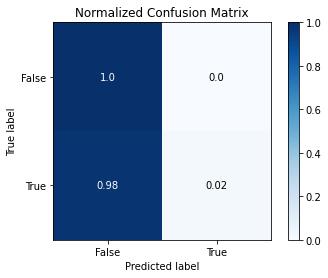

In [37]:
#imprimir relatorio de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

#matriz de confusao
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

Nota-se que em precision (precisão alcançada em cada classe) o modelo acertou 84% de casos False mas em contra partida acertou somente 57% dos casos True (clientes inamdiplente).

Já o recall (número de acertos) para a classe False é muito alta mas para a classe True é quase zerada. 

Ou seja, o modelo aprendeu mais sobre a classe que ele tinha maiores quantidades de exemplos.

Para melhorarmos este desempenho, irei *balancear os dados*. Para este projeto irei usar *dois métodos* e avaliar em qual o modelo se sairá melhor.


**Balanceando os dados com a técnica SMOTE**

Este método vai gerar dados sintéticos da classe minoritária a partir de vizinhos.

In [24]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_os, y_os = oversample.fit_resample(x, y)

True     35080
False    35080
dtype: int64


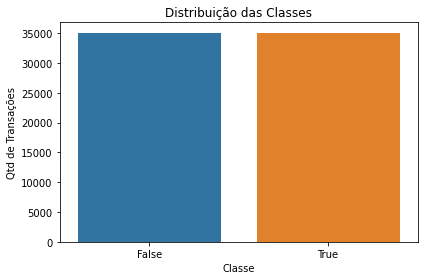

In [25]:
#grafico da nova distribuição de classes
fig, ax = plt.subplots()
sns.countplot(y_os, ax=ax)
ax.set_title('Distribuição das Classes')
plt.xlabel('Classe')
plt.ylabel('Qtd de Transações')
plt.tight_layout();

#print do balanceamento
print(pd.Series(y_os).value_counts())

Após o balanceamento, instanciamos e testamos modelo novamente. Dessa vez mudarei alguns parametros do XGBoost.

In [26]:
#dividir o dataset entre treino e teste
x_train, x_test, y_train, y_test = train_test_split(x_os, y_os)

#instanciando e treinando o modelo
ml_model= XGBClassifier(learning_rate=0.01, n_estimators= 100, max_depth=4,
                        subsample = 0.8, colsample_bytree = 0.3, gamma=5,)
ml_model.fit(x_train, y_train)

#previsao e probabilidade encima do dataset de teste
y_pred = ml_model.predict(x_test)


Relatório de Classificação:
               precision    recall  f1-score   support

       False     0.8204    0.9984    0.9007      8875
        True     0.9979    0.7761    0.8731      8665

    accuracy                         0.8886     17540
   macro avg     0.9092    0.8873    0.8869     17540
weighted avg     0.9081    0.8886    0.8871     17540



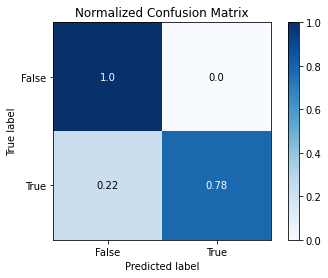

In [27]:
#imprimir relatorio de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

#matriz de confusao
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()


Pelas métricas de avaliação o modelo atingiu ótimos resultados.

A acurácia foi de 89%.

Analisando esta matriz temos:

* False Positive - 100%
* False Negative - 22%
* True Positive - 78% 
* True Negative - 0%


Ou seja, das classificações onde eram falsos positivos o modelo acertou praticamente 100%, e falsos negativo o modelo errou em 22%.



 **Balanceando os dados com RandomUnderSampler**

 Este método reduz de forma aleatória os exemplos da classe majoritária.

In [28]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
x_rus, y_rus = rus.fit_sample(x, y)

True     6661
False    6661
dtype: int64


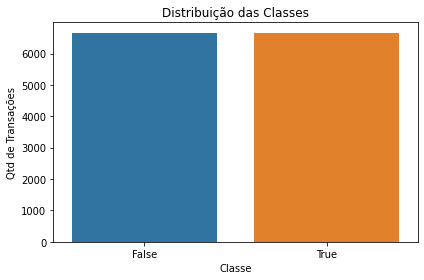

In [29]:
#grafico da nova distribuição de classes
fig, ax = plt.subplots()
sns.countplot(y_rus, ax=ax)
ax.set_title('Distribuição das Classes')
plt.xlabel('Classe')
plt.ylabel('Qtd de Transações')
plt.tight_layout();

#print do balanceamento
print(pd.Series(y_rus).value_counts())

Após o balanceamento, instanciamos e testamos novamente também.

In [32]:
#dividir o dataset entre treino e teste
x_train, x_test, y_train, y_test = train_test_split(x_rus, y_rus)

#instanciando e treiando o modelo
ml_model= XGBClassifier(learning_rate=0.01, n_estimators= 100, max_depth=4,
                        subsample = 0.8, colsample_bytree = 0.3, gamma=5,)
ml_model.fit(x_train, y_train)

#previsao e probabilidade encima do dataset de teste
y_pred = ml_model.predict(x_test)

Relatório de Classificação:
               precision    recall  f1-score   support

       False     0.6248    0.6921    0.6567      1653
        True     0.6607    0.5906    0.6237      1678

    accuracy                         0.6409      3331
   macro avg     0.6427    0.6413    0.6402      3331
weighted avg     0.6429    0.6409    0.6401      3331



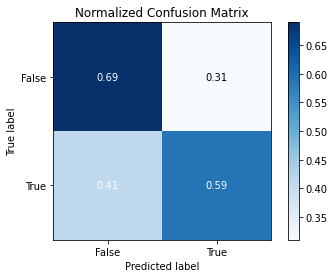

In [33]:
#imprimir relatorio de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

#plotar matriz de confusao
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()


 Por aqui podemos ver que o modelo nao se comportou tão bem com o balanceamento efetuado.

 A acurácia do modelo foi de 64%.

 Vamos para matriz de confusão:

* False Positive - 69%
* False Negative - 31%
* True Positive - 59% 
* True Negative - 41%


Ou seja, das classificações onde eram falsos positivos o modelo acertou 66%, e falsos negativo o modelo errou em 41% (19% a mais do que o outro modelo).

**CONSIDERAÇÕES FINAIS**

Usar um modelo de algoritmo para prever e/ou classificar, contribui em muito para um negócio, mas para que atinga bons resultados, à toda uma complexidade por trás. É preciso analisar com atenção os dados e usar boas ferramentas antes de partirmos para criação de um modelo e elas fazem toda a diferença. Essa etapa pode ser longa e cansativa mas vale por todo o esforço.

Neste projeto pude ver isso na prática, a análise foi bem extensa e utilizei ferramentas que auxiliaram para que o modelo pudesse ser treinado e testado da melhor maneira, e ainda assim, alguns dos métodos utilizados nem sempre trazem resultados tão eficientes quanto precisamos.

 Finalizo enfatizando que todo modelo pode ser melhorado, melhor parametrizado e avaliado depois que os dados estejam preparados.
